In [2]:
import os
os.chdir("..")

In [3]:
from torch_geometric.data import Data
import glob
from tqdm import tqdm
import torch
from utils import get_classification_model

In [4]:
import pickle
import gzip
from collections import defaultdict

In [5]:
from params import CLASSIFIER_PARAMS

In [6]:
CLASSIFIER_PARAMS["features"] = 150
CLASSIFIER_PARAMS["classes"] = 1
CLASSIFIER_PARAMS["edge_dim"] = None
model = get_classification_model(CLASSIFIER_PARAMS)
model.load("results/REVEAL_CLASSIFIER_LINEVUL_baseline/checkpoint/")

In [7]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

719033

In [8]:
import csv
csv.field_size_limit(1000000000)
groundtruth = {}
with open("data/test.csv", 'r', newline='', encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            if row["target"] == "0":
                continue
            if row["flaw_line"] is None:
                 continue
            groundtruth[row["index"]] = row["flaw_line"].split("/~/")

0it [00:00, ?it/s]

18864it [00:09, 1909.34it/s]


In [10]:
import re

@torch.no_grad()
def sort_lines(scores):
    _, indices = torch.sort(torch.as_tensor(scores), descending=True)
    return indices.tolist()


def get_flaw_indices(lines, flaw_lines):
    indices = []
    def clean(line):
        # line = re.sub("^\s", "", line)
        # line = re.sub("\s$", "", line)
        line = re.sub("\s", "", line)
        return line
    flaw_lines = [clean(flaw_line) for flaw_line in flaw_lines if len(clean(flaw_line)) != 0]
    lines = [clean(line) for line in lines]

    for i, line in enumerate(lines):
        if len(line) == 0:
            continue
        if any(line in flaw_line for flaw_line in flaw_lines) or \
            any(flaw_line in line for flaw_line in flaw_lines):
            indices.append(i)
    return indices


def min_rank_of_indices(sorted_indices, searched_indices):
    rank_mapping = {index: rank for rank, index in enumerate(sorted_indices)}
    return min(
        (rank_mapping[index] for index in searched_indices if index in rank_mapping),
        default=float("inf"),
    )

def get_c_lines(idx, set="test", label=1):
    with open(f"data/test/{set}/{idx}_{label}.c", "r", encoding="utf-8") as f:
        return f.readlines()

In [11]:
from torchray.attribution.common import (
    NullContext,
    gradient_to_saliency,
    get_backward_gradient,
    attach_debug_probes,
    get_module,
    Probe,
    resize_saliency,
    imsmooth,
)

from torch_geometric.nn.pool import global_mean_pool

def gradient_to_grad_cam_saliency(x, batch):
    r"""Convert activation and gradient to a Grad-CAM saliency map.
    The tensor :attr:`x` must have a valid gradient ``x.grad``.
    The function then computes the saliency map :math:`s`: given by:
    .. math::
        s_{n1u} = \max\{0, \sum_{c}x_{ncu}\cdot dx_{ncu}\}
    Args:
        x (:class:`torch.Tensor`): activation tensor with a valid gradient.
    Returns:
        :class:`torch.Tensor`: saliency map.
    """
    # Apply global average pooling (GAP) to gradient.

    # problem mit batch_size groesser eins (graphen beeinflussen sich gegenseitig)
    # grad_weight = torch.mean(x.grad, 0, keepdim=True)
    grad_weight = global_mean_pool(x.grad, batch)
    grad_weight_batched = grad_weight[batch]

    # Linearly combine activations and GAP gradient weights.

    # saliency_map = torch.sum(grad_weight * x, 1, keepdim=True)
    # saliency_map = torch.matmul(x, grad_weight.view(-1))
    saliency_map = torch.sum(x * grad_weight_batched, -1)
    # Apply ReLU to visualization.
#     saliency_map = torch.clamp(saliency_map, min=0)
    saliency_map = abs(saliency_map)
    return saliency_map

def saliency(model,
             input,
             target,
             saliency_layer='',
             resize=False,
             resize_mode='bilinear',
             smooth=0,
             context_builder=NullContext,
             gradient_to_saliency=gradient_to_saliency,
             get_backward_gradient=get_backward_gradient,
             debug=False):
    """
    monkey-patch torchray saliency
    """

    # Clear any existing gradient.
    # if input.grad is not None:
    #     input.grad.data.zero_()

    # Disable gradients for model parameters.
    # orig_requires_grad = {}
    # for name, param in model.named_parameters():
    #     orig_requires_grad[name] = param.requires_grad
    #     param.requires_grad_(False)

    # Set model to eval mode.
    model.train()
    if model.training:
        orig_is_training = True
        # model.eval()
    else:
        orig_is_training = False

    # Attach debug probes to every module.
    debug_probes = attach_debug_probes(model, debug=debug)

    # Attach a probe to the saliency layer.
    probe_target = 'input' if saliency_layer == '' else 'output'
    saliency_layer = get_module(model, saliency_layer)
    assert saliency_layer is not None, 'We could not find the saliency layer'
    probe = Probe(saliency_layer, target=probe_target)

    # Do a forward and backward pass.
    with context_builder():
        output = model.loss(input)[0]
        # backward_gradient = get_backward_gradient(output, target)
        output.backward()

    # Get saliency map from gradient.
    saliency_map = gradient_to_saliency(probe.data[0], input.batch)

    # Resize saliency map.
    saliency_map = resize_saliency(input.x,
                                   saliency_map,
                                   resize,
                                   mode=resize_mode)

    # Smooth saliency map.
    if smooth > 0:
        saliency_map = imsmooth(
            saliency_map,
            sigma=smooth * max(saliency_map.shape[2:]),
            padding_mode='replicate'
        )

    # Remove probe.
    probe.remove()

    # Restore gradient saving for model parameters.
    # for name, param in model.named_parameters():
    #     param.requires_grad_(orig_requires_grad[name])

    # Restore model's original mode.
    if orig_is_training:
        model.train()

    if debug:
        return saliency_map, debug_probes
    else:
        return saliency_map

def grad_cam(*args,
             saliency_layer,
             gradient_to_saliency=gradient_to_grad_cam_saliency,
             **kwargs):
    return saliency(*args,
                    saliency_layer=saliency_layer,
                    gradient_to_saliency=gradient_to_saliency,
                    **kwargs,)

In [12]:
model

GraphClassifier(
  (encoder): CompositeGraphLevelEncoder(
    (node_level_encoder): GGNNEncoder(
      (layers): ModuleList()
      (norms): ModuleList()
      (ggnn): GatedGraphConv(200, num_layers=8)
      (out): Linear(in_features=200, out_features=200, bias=True)
    )
  )
  (classifier): MLPClassifier(
    (layers): ModuleList(
      (0): Linear(in_features=200, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [20]:
def eval_linelevel_merged(CPG_SET, C_SET):
    ranks = []
    with open("data/merged.txt", "r") as f:
        successful_idxs = set(f.read().split("\n"))
    print(f"Evaluating {CPG_SET}")
    for name in list(map(lambda idx: f"cache/{CPG_SET}/{idx}_1.cpg.pt.gz", successful_idxs)):
        idx = name.split("/")[-1].split("_")[0]
        if idx not in groundtruth:
            continue

        c_lines = get_c_lines(idx, C_SET)
        flaw_indices = get_flaw_indices(c_lines, groundtruth[idx])
        if len(flaw_indices) < 1:
            continue

        object_file = pickle.load(gzip.open(name))
        data = Data(x=torch.cat((object_file["astenc"], object_file["codeenc"]), dim=1), edge_index=object_file["edge_index"], y=object_file["y"])
        data.edge_index = data.edge_index.long()
        data.x = data.x.float()
        
        target = torch.tensor([1.], requires_grad=True)

        node_c = grad_cam(model, data, target, saliency_layer="encoder.node_level_encoder.ggnn")[0]
        node_mask = node_c.sigmoid()

        linescores = defaultdict(int)
        for node_idx, score in enumerate(node_mask):
            if ":" not in object_file["lines"][node_idx]:
                continue
            lower = int(object_file["lines"][node_idx].split(" ")[0].split(":")[0].replace("\"",""))
            upper = int(object_file["lines"][node_idx].split(" ")[0].split(":")[1].replace("\"",""))
            lines = list(range(int(lower), int(upper)+1))
            for line in lines:
                linescores[line] += score/len(lines)
        lines = [0 for _ in range(max(linescores.keys()))]
        for line, score in linescores.items():
            lines[line-1] = score
        
        sorted_lines = sort_lines(lines)
        rank = min_rank_of_indices(sorted_lines, flaw_indices)
        ranks.append(rank)
    ranks = torch.as_tensor(ranks)
    ranks = ranks[ranks.isfinite()]
    def topk_acc(k):
            return round((
                torch.sum(ranks < k) / len(ranks)
            ).item() * 100, 2)
    print({
        "Top1-Acc": topk_acc(1),
        "Top3-Acc": topk_acc(3),
        "Top5-Acc": topk_acc(5),
    })
    """print({
        "Top1-Acc": torch.sum(ranks < 1) / len(ranks),
        "Top2-Acc": torch.sum(ranks < 2) / len(ranks),
        "Top3-Acc": torch.sum(ranks < 3) / len(ranks),
        "Top5-Acc": torch.sum(ranks < 5) / len(ranks),
        "Top10-Acc": torch.sum(ranks < 10) / len(ranks),
        # "Top100-Acc": torch.sum(ranks < 100) / len(ranks),
        # "IFA": torch.mean(ranks.float()),
        "Count": len(ranks),
    })"""

In [21]:
eval_linelevel_merged("LINEVUL_TEST", "test")

Evaluating LINEVUL_TEST
{'Top1-Acc': 43.09, 'Top3-Acc': 59.67, 'Top5-Acc': 67.96}


In [22]:
eval_linelevel_merged("LINEVUL_CHROMIUM", "apply_codestyle_Chromium")

Evaluating LINEVUL_CHROMIUM
{'Top1-Acc': 44.2, 'Top3-Acc': 60.77, 'Top5-Acc': 69.61}


In [23]:
eval_linelevel_merged("LINEVUL_GNU", "apply_codestyle_GNU")

Evaluating LINEVUL_GNU
{'Top1-Acc': 39.78, 'Top3-Acc': 59.12, 'Top5-Acc': 68.51}


In [24]:
eval_linelevel_merged("LINEVUL_GOOGLE", "apply_codestyle_Google")

Evaluating LINEVUL_GOOGLE
{'Top1-Acc': 44.75, 'Top3-Acc': 61.33, 'Top5-Acc': 69.61}


In [25]:
eval_linelevel_merged("LINEVUL_LLVM", "apply_codestyle_LLVM")

Evaluating LINEVUL_LLVM
{'Top1-Acc': 44.2, 'Top3-Acc': 61.33, 'Top5-Acc': 69.61}


In [26]:
eval_linelevel_merged("LINEVUL_MOZILLA", "apply_codestyle_Mozilla")

Evaluating LINEVUL_MOZILLA
{'Top1-Acc': 43.65, 'Top3-Acc': 61.88, 'Top5-Acc': 70.72}


In [13]:
from scipy.stats import nhypergeom

def expected_rank(count_lines, count_flaw_lines):
    dist = nhypergeom(count_lines, count_lines - count_flaw_lines, 1)
    return dist.mean()

In [14]:
def eval_linelevel_expected(CPG_SET, C_SET):
    ranks = []
    with open("data/merged.txt", "r") as f:
        successful_idxs = set(f.read().split("\n"))
    print(f"Evaluating {CPG_SET}")
    for name in list(map(lambda idx: f"cache/{CPG_SET}/{idx}_1.cpg.pt.gz", successful_idxs)):
        idx = name.split("/")[-1].split("_")[0]
        if idx not in groundtruth:
            continue

        c_lines = get_c_lines(idx, C_SET)
        flaw_indices = get_flaw_indices(c_lines, groundtruth[idx])
        if len(flaw_indices) < 1:
            continue

        object_file = pickle.load(gzip.open(name))
        data = Data(x=torch.cat((object_file["astenc"], object_file["codeenc"]), dim=1), edge_index=object_file["edge_index"], y=object_file["y"])
        
        node_mask = torch.rand(data.x.shape[:-1]).sigmoid()

        linescores = defaultdict(int)
        for node_idx, score in enumerate(node_mask):
            if ":" not in object_file["lines"][node_idx]:
                continue
            lower = int(object_file["lines"][node_idx].split(" ")[0].split(":")[0].replace("\"",""))
            upper = int(object_file["lines"][node_idx].split(" ")[0].split(":")[1].replace("\"",""))
            lines = list(range(int(lower), int(upper)+1))
            for line in lines:
                linescores[line] += score/len(lines)
        lines = [0 for _ in range(max(linescores.keys()))]
        for line, score in linescores.items():
            lines[line-1] = score
        
        ranks.append(expected_rank(len(lines), len(flaw_indices)))
    ranks = torch.as_tensor(ranks)
    ranks = ranks[ranks.isfinite()]
    def topk_acc(k):
            return round((
                torch.sum(ranks < k) / len(ranks)
            ).item() * 100, 2)
    print({
        "Top1-Acc": topk_acc(1),
        "Top3-Acc": topk_acc(3),
        "Top5-Acc": topk_acc(5),
    })

In [15]:
eval_linelevel_expected("LINEVUL_TEST", "test")

Evaluating LINEVUL_TEST
{'Top1-Acc': 26.86, 'Top3-Acc': 46.86, 'Top5-Acc': 57.71}


In [16]:
eval_linelevel_expected("LINEVUL_CHROMIUM", "apply_codestyle_Chromium")

Evaluating LINEVUL_CHROMIUM
{'Top1-Acc': 26.86, 'Top3-Acc': 46.86, 'Top5-Acc': 57.71}


In [17]:
eval_linelevel_expected("LINEVUL_MOZILLA", "apply_codestyle_Mozilla")

Evaluating LINEVUL_MOZILLA
{'Top1-Acc': 25.71, 'Top3-Acc': 45.14, 'Top5-Acc': 57.71}


In [18]:
eval_linelevel_expected("LINEVUL_GOOGLE", "apply_codestyle_Google")

Evaluating LINEVUL_GOOGLE
{'Top1-Acc': 28.57, 'Top3-Acc': 47.43, 'Top5-Acc': 57.71}


In [19]:
eval_linelevel_expected("LINEVUL_LLVM", "apply_codestyle_LLVM")

Evaluating LINEVUL_LLVM
{'Top1-Acc': 28.57, 'Top3-Acc': 46.86, 'Top5-Acc': 57.71}


In [57]:

preds = []
labels = []
lens = []
CPG_SET = "LINEVUL_TEST"
C_SET = "test"
print(f"Evaluating {CPG_SET}")
for name in tqdm(list(glob.glob(f"./cache/{CPG_SET}/*.cpg.pt.gz"))):
    name = name.replace("\\", "/")
    idx = name.split("/")[-1].split("_")[0]
    label = int(name.split("/")[-1].split("_")[-1].split(".")[0])

    c_lines = get_c_lines(idx, C_SET, label=label)

    object_file = pickle.load(gzip.open(name))
    data = Data(x=torch.cat((object_file["astenc"], object_file["codeenc"]), dim=1), edge_index=object_file["edge_index"], y=object_file["y"])
    data.edge_index = data.edge_index.long()
    data.x = data.x.float()

    pred = model.classify(data)

    preds.append(pred.item())
    labels.append(label)
    lens.append(len("".join(c_lines)))


Evaluating LINEVUL_TEST


100%|██████████| 9960/9960 [07:19<00:00, 22.69it/s]


In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
preds = np.asarray(preds)
preds[preds >= 0] = 1
preds[preds < 0] = 0

In [59]:
correct = preds == labels

In [100]:
tp = len(lens[(preds == 1) & correct])
tn = len(lens[(preds == 0) & correct])
fp = len(lens[(preds == 1) & ~correct])
fn = len(lens[(preds == 0) & ~correct])

((tp/(tp+fn)) + (tn/(tn+fp)))/2

0.6318049749839368

In [60]:
lens = np.asarray(lens)
filtered_correct = correct[lens < 10_000]
filtered_lens = lens[lens < 10_000]

In [74]:
labels = np.asarray(labels)

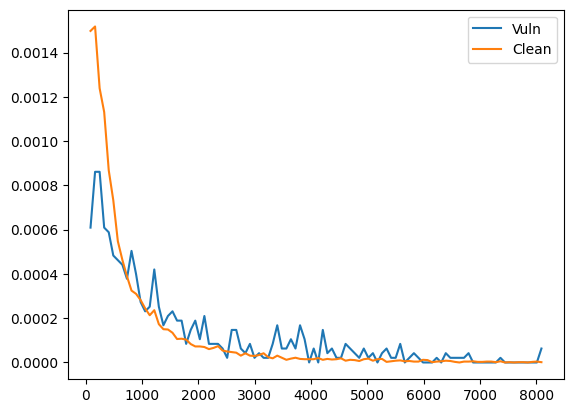

In [78]:
vuln_lens = lens[labels == 1]
clean_lens = lens[labels == 0]

vuln_lens = vuln_lens[vuln_lens < 10_000]
clean_lens = clean_lens[clean_lens < 10_000]

vuln_counts, edges = np.histogram(vuln_lens, bins=100, density=True)
clean_counts, _ = np.histogram(clean_lens, bins=edges, density=True)

plt.plot(edges[:-1], vuln_counts, label="Vuln")
plt.plot(edges[:-1], clean_counts, label="Clean")
plt.legend()

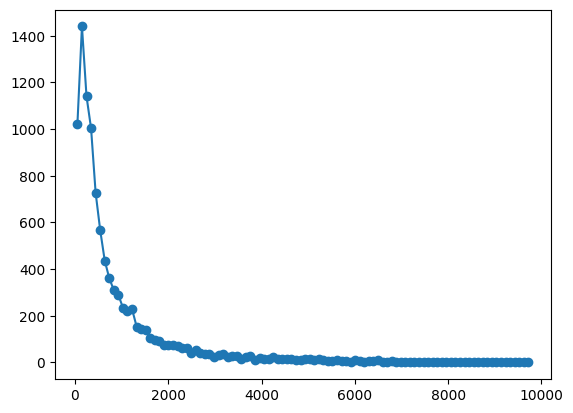

In [61]:
counts, edges = np.histogram(filtered_lens, bins=100)
plt.plot(edges.tolist()[:-1], counts, marker="o")
plt.yscale("linear")

C:\Users\I518118\AppData\Local\Temp\ipykernel_26720\1703238288.py:2: RuntimeWarning: invalid value encountered in divide
  H_correct = H[:, -1] / np.sum(H, axis=-1)


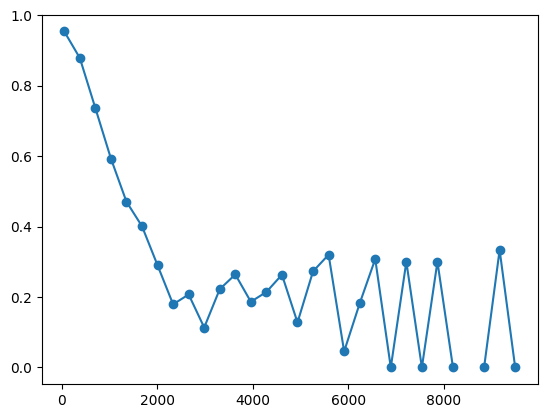

In [62]:
H, xedges, yedges = np.histogram2d(filtered_lens, filtered_correct, bins=30)
H_correct = H[:, -1] / np.sum(H, axis=-1)
plt.plot(xedges[:-1], H_correct, marker="o")

In [81]:
filtered_preds = preds[lens < 10_000]
filtered_labels = labels[lens < 10_000]

C:\Users\I518118\AppData\Local\Temp\ipykernel_26720\2755590405.py:13: RuntimeWarning: invalid value encountered in divide
  tpr_binned = tp_binned / (tp_binned + fn_binned)
C:\Users\I518118\AppData\Local\Temp\ipykernel_26720\2755590405.py:14: RuntimeWarning: invalid value encountered in divide
  tnr_binned = tn_binned / (tn_binned + fp_binned)


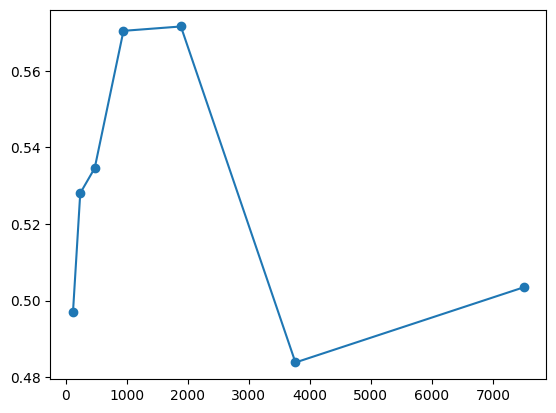

In [116]:
_, xedges = np.histogram(filtered_lens, bins=[0] + np.logspace(np.log10(20), np.log10(10_000), 10).tolist())

filtered_tps = filtered_lens[(filtered_preds == 1) & filtered_correct]
filtered_tns = filtered_lens[(filtered_preds == 0) & filtered_correct]
filtered_fps = filtered_lens[(filtered_preds == 1) & ~filtered_correct]
filtered_fns = filtered_lens[(filtered_preds == 0) & ~filtered_correct]

tp_binned = np.histogram(filtered_tps, bins=xedges)[0]
tn_binned = np.histogram(filtered_tns, bins=xedges)[0]
fp_binned = np.histogram(filtered_fps, bins=xedges)[0]
fn_binned = np.histogram(filtered_fns, bins=xedges)[0]

tpr_binned = tp_binned / (tp_binned + fn_binned)
tnr_binned = tn_binned / (tn_binned + fp_binned)

bacc_binned = (tpr_binned + tnr_binned) / 2

xvals = (xedges[1:] + xedges[:-1])/2
plt.plot(xvals, bacc_binned, marker="o")

In [56]:
np.sum(H[:, -1]) / np.sum(H)

0.7621758380771664